# Exploring meta-data

In [1]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
DATA_DIR = "../Data/Grain-Data-RGB"

In [6]:
def load_and_clean_files(files_dir):
    files = os.listdir(files_dir)
    if ".DS_Store" in files:
        files.remove(".DS_Store")
    return files

def extract_metadata(filename):
    """
    Extracts metadata from filename
    """
    grain_match = re.search(r"grain(?P<grainID>\d+)", filename)
    var_match   = re.search(r"var(?P<varietyNumber>\d+)", filename)
    micro_match = re.search(r"x(?P<x>\d+)y(?P<y>\d+)", filename)
    time_match  = re.search(
        r"2x_(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})T(?P<timestamp>\d+)_corr",
        filename
    )

    if not all([grain_match, var_match, micro_match, time_match]):
        return None

    return {
        "grainID": grain_match.group("grainID"),
        "varietyNumber": var_match.group("varietyNumber"),
        "microplotID": f"x{micro_match.group('x')}y{micro_match.group('y')}",
        "year": time_match.group("year"),
        "month": time_match.group("month"),
        "day": time_match.group("day"),
        "timestamp": time_match.group("timestamp"),
        "filename": filename
    }


In [7]:
# Load data files
data_files_rgb = load_and_clean_files(DATA_DIR)

In [8]:
# Extract metadata from filenames
all_metadata = [extract_metadata(file) for file in data_files_rgb if extract_metadata(file)]

In [9]:
# convert metadata to pandas dataframe
df = pd.DataFrame(all_metadata)
df

,grainID,varietyNumber,microplotID,year,month,day,timestamp,filename
0,23632,7,x72y15,2021,10,23,144229,grain23632_var7-x72y15_7000_us_2x_2021-10-23T1...
1,7795,6,x40y20,2020,12,02,134036,grain7795_x40y20-var6_8000_us_2x_2020-12-02T13...
2,7511,5,x39y20,2020,12,02,131556,grain7511_x39y20-var5_8000_us_2x_2020-12-02T13...
3,16801,2,x76y12,2021,10,19,160332,grain16801_var2-x76y12_7000_us_2x_2021-10-19T1...
4,7613,5,x39y20,2020,12,02,132032,grain7613_x39y20-var5_8000_us_2x_2020-12-02T13...
...,...,...,...,...,...,...,...,...
26877,23093,6,x80y20,2021,10,19,150717,grain23093_var6-x80y20_7000_us_2x_2021-10-19T1...
26878,18368,3,x81y18,2021,10,23,150202,grain18368_var3-x81y18_7000_us_2x_2021-10-23T1...
26879,15566,2,x73y16,2021,10,19,155300,grain15566_var2-x73y16_7000_us_2x_2021-10-19T1...
26880,14254,1,x73y14,2021,10,23,151816,grain14254_var1-x73y14_7000_us_2x_2021-10-23T1...


In [11]:
# Save df to csv
df.to_csv("../Data/Grain-Data-RGB.csv", index=False)

# Exploring data
Loading random data files and visualizing them

In [12]:
def load_data(dir, filename):
    return np.load(os.path.join(dir, filename))

def band_brightness_npz(cube, k):
    """Approximation of the original Spectralon normalization."""
    band = cube[:, :, k]
    # avoid division by zero
    return np.mean(band) if np.mean(band) != 0 else 1.0


def plot_random_data(files, dir):
    N = 20
    sample_files = random.sample(files, N)
    cols = 5                   
    rows = math.ceil(N / cols) 

    plt.figure(figsize=(cols * 1.0, rows * 1.0))

    for i, f in enumerate(sample_files, 0):
        data = load_data(dir=dir, filename=f)
        img = data["x"]
        # Apply per-band brightness correction
        r = img[:, :, 0] / band_brightness_npz(img, 0)
        g = img[:, :, 1] / band_brightness_npz(img, 1)
        b = img[:, :, 2] / band_brightness_npz(img, 2)
        img = np.dstack((b, g, r))
        y = data["y"]


        # Normalize per image
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img_norm = (img - vmin) / (vmax - vmin)
        else:
            img_norm = np.zeros_like(img)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_norm)
        plt.axis("off")

    plt.tight_layout(pad=0.1)
    plt.show()


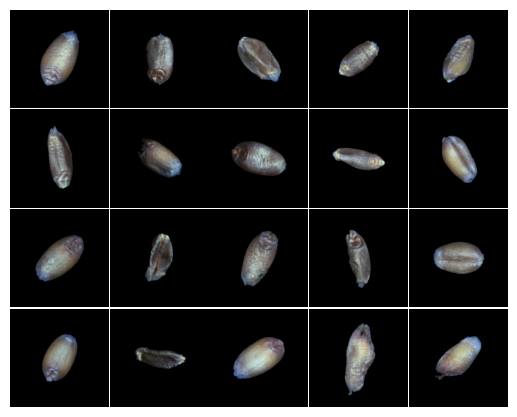

In [13]:
plot_random_data(files=data_files_rgb, dir=DATA_DIR)